In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
import wandb
import gc
import torchvision.models as models
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

c:\Users\panda\OneDrive\Documents\Coding_Stuff\Computer Vision\venv_py311_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset_Preparation and Sampling

In [3]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 50
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [8]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = models.vgg16(weights=models.VGG16_Weights)
        self.features = self.base_model.features
        # Freeze the feature layers
        for param in self.features.parameters():
            param.requires_grad = False
        # Change the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGGNet().to(device)
summary(model)  # Great whay to look overall what is hapening inside your model

Layer (type:depth-idx)                   Param #
VGGNet                                   --
├─VGG: 1-1                               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18  

## Correct and optimised training loop

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/50] | Loss: 1.0282 | Train Acc: 0.7455 | Val Acc: 0.8213
Epoch [2/50] | Loss: 0.6309 | Train Acc: 0.8639 | Val Acc: 0.8167
Epoch [3/50] | Loss: 0.9016 | Train Acc: 0.8790 | Val Acc: 0.8445
Epoch [4/50] | Loss: 0.7928 | Train Acc: 0.9111 | Val Acc: 0.8399
Epoch [5/50] | Loss: 1.0603 | Train Acc: 0.9210 | Val Acc: 0.8353
Epoch [6/50] | Loss: 1.5621 | Train Acc: 0.9262 | Val Acc: 0.8469
Epoch [7/50] | Loss: 1.7887 | Train Acc: 0.9294 | Val Acc: 0.8492
Epoch [8/50] | Loss: 1.3939 | Train Acc: 0.9441 | Val Acc: 0.8608
Epoch [9/50] | Loss: 1.0370 | Train Acc: 0.9595 | Val Acc: 0.8422
Epoch [10/50] | Loss: 1.2747 | Train Acc: 0.9618 | Val Acc: 0.8770
Epoch [11/50] | Loss: 0.9151 | Train Acc: 0.9716 | Val Acc: 0.8724
Epoch [12/50] | Loss: 1.2576 | Train Acc: 0.9653 | Val Acc: 0.8817
Epoch [13/50] | Loss: 1.7819 | Train Acc: 0.9632 | Val Acc: 0.8817
Epoch [14/50] | Loss: 1.0162 | Train Acc: 0.9765 | Val Acc: 0.8724
Epoch [15/50] | Loss: 0.9014 | Train Acc: 0.9794 | Val Acc: 0.8608
Epoc

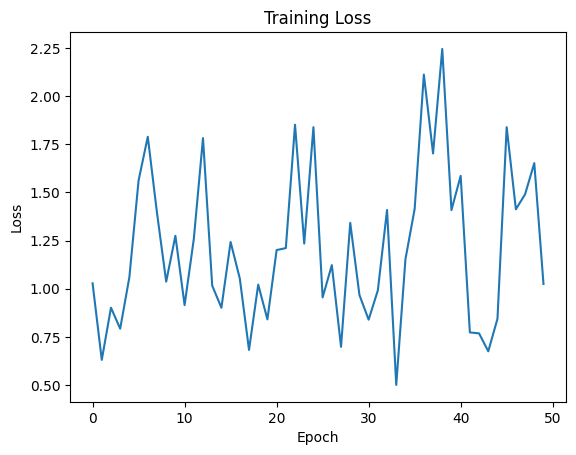

In [11]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

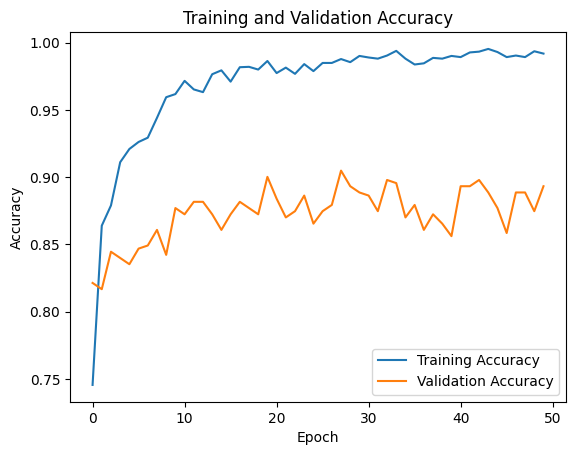

In [13]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [12]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.8866
Final train Accuracy: 0.9919
Final validation Accuracy: 0.8933


Using a pretrained VGGNet with a custom classifier significantly improves performance compared to training a network from scratch. Fine-tuning allows the pretrained convolutional features to adapt to our specific task efficiently, while the added classifier learns to map these features to our target classes.

The final training accuracy reaches 99.2%, with a validation accuracy of 89.3% and overall test accuracy of 88.7%, showing strong generalization to unseen data. The small gap between training and validation accuracy indicates minor overfitting but overall solid performance.

These results highlight the effectiveness of transfer learning: leveraging pretrained features accelerates learning and boosts accuracy without the need for full training from scratch.